# Python時系列データ分析入門（解説用）

## データの読み込み
* read_csv: CSVファイルをDataFrameオブジェクトとして読み込む
* CSV: Comma-Separated Values
* DataFrame: 二次元行列データの格納、加工に適している  
CSV -> DataFrame -> numpy
* head: 最初の5行を表示
* tail: 最後の5行を表示

In [1]:
import pandas as pd

df = pd.read_csv("pv_ver00.csv") 
df.head()

,date,user,view
0,2017/1/1,47,129
1,2017/1/2,55,111
2,2017/1/3,52,180
3,2017/1/4,92,162
4,2017/1/5,113,266


* info: Dataframeの**データ数**、データの型などの情報を表示

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 3 columns):
date    642 non-null object
user    642 non-null int64
view    642 non-null int64
dtypes: int64(2), object(1)
memory usage: 15.1+ KB


* index_col: 行番号以外をインデックスとして指定
* parse_dates: True ⇒ 日付を分割する  
e.g. '1988/06/11' (False) -> '1988-06-11' (True): '1988-06'など月単位で指定できるようになる
* dropna: nanなどの欠損値をdrop(除去)
* nan: Not A Number

In [3]:
df = pd.read_csv('pv_ver00.csv', index_col='date',
                 parse_dates=True, dtype=float)
df = df.dropna() #NaN データを削除(ドロップdrop) している
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 642 entries, 2017-01-01 to 2018-10-04
Data columns (total 2 columns):
user    642 non-null float64
view    642 non-null float64
dtypes: float64(2)
memory usage: 15.0 KB


* loc: LOCation  
列（や行）を文字列によって範囲を指定し抽出  
※列のみであれば
* iloc: Integer LOCation  
列（や行）を整数によって範囲を指定して抽出

In [4]:
# pandas の関数 loc() => location 
train = df.loc[:'2018-06-30', ['user']] # 2018-06-30より前のuser列を抽出
test = df.loc[:, ['user']] # 全期間のuser列を抽出
test.head()

,user
date,
2017-01-01,47.0
2017-01-02,55.0
2017-01-03,52.0
2017-01-04,92.0
2017-01-05,113.0


## データの可視化

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


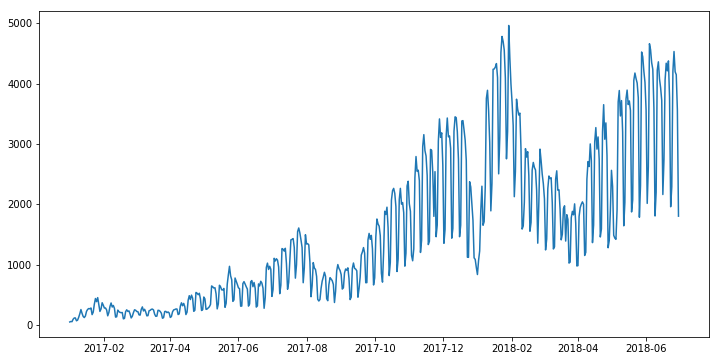

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train)
plt.show()

## 前処理

### 階差

In [6]:
train.head()

,user
date,
2017-01-01,47.0
2017-01-02,55.0
2017-01-03,52.0
2017-01-04,92.0
2017-01-05,113.0


In [7]:
train.shift().head() # shift(): 1つずらした値

,user
date,
2017-01-01,NaN
2017-01-02,47.0
2017-01-03,55.0
2017-01-04,52.0
2017-01-05,92.0


In [8]:
train_dif = train - train.shift() # 訓練データの階差
test_dif = test - test.shift() # テストデータの階差

train_dif, test_dif = train_dif.dropna(), test_dif.dropna()
train_dif.head()

,user
date,
2017-01-02,8.0
2017-01-03,-3.0
2017-01-04,40.0
2017-01-05,21.0
2017-01-06,1.0


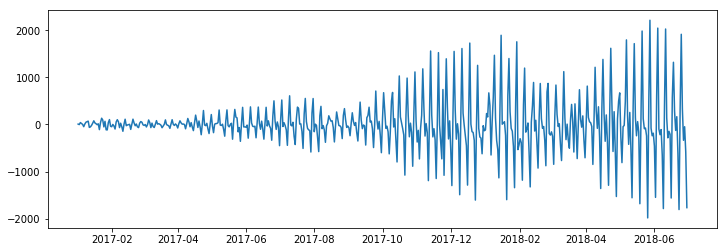

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(train_dif)
plt.show()

### 対数変換

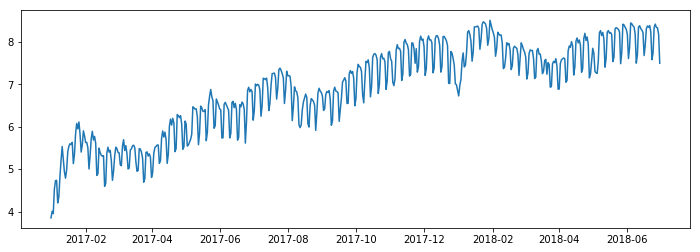

In [10]:
import numpy as np

train_log = np.log(train)

plt.figure(figsize=(12, 4))
plt.plot(train_log)
plt.show()

### 対数差分

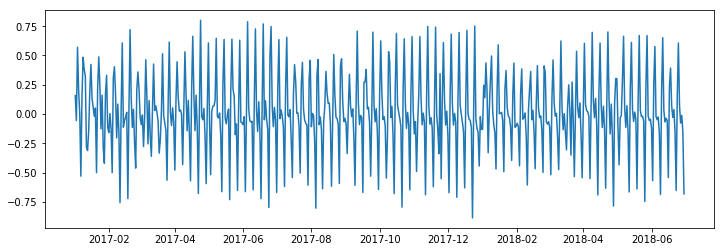

In [11]:
train_log_dif = train_log - train_log.shift()
train_log_dif = train_log_dif.dropna()
plt.figure(figsize=(12, 4))
plt.plot(train_log_dif)
plt.show()

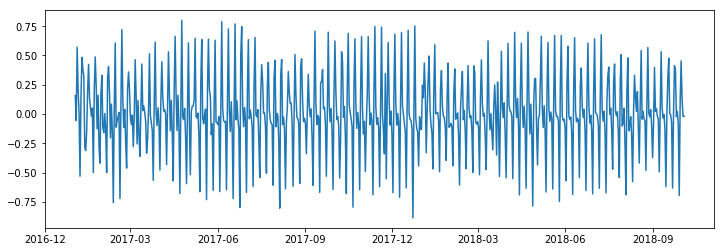

In [12]:
test_log = np.log(test)
test_log_dif = test_log - test_log.shift()
plt.figure(figsize=(12, 4))
plt.plot(test_log_dif)
plt.show()

***
## 自己相関  
* tsa: Time Series Analysis  
* acf: AutoCorrelation Function
* nlags: 自己相関の次数

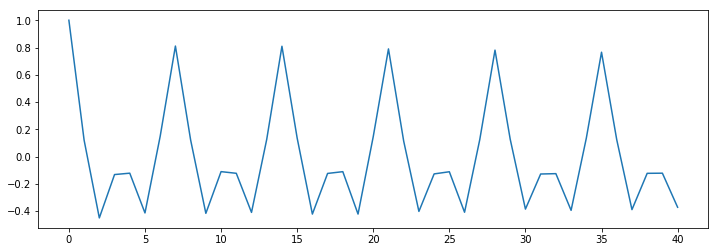

In [13]:
import statsmodels.api as sm

train_acf = sm.tsa.stattools.acf(train_log_dif, nlags=40)
fig = plt.figure(figsize=(12, 4))
plt.plot(train_acf)
plt.show()

## 偏自己相関  
* pacf: Partial AutoCorrelation Function（偏自己相関）
* ols: Ordinary Least Squares regression（最小二乗回帰）
* 他にもywunbiased: yule walker法など

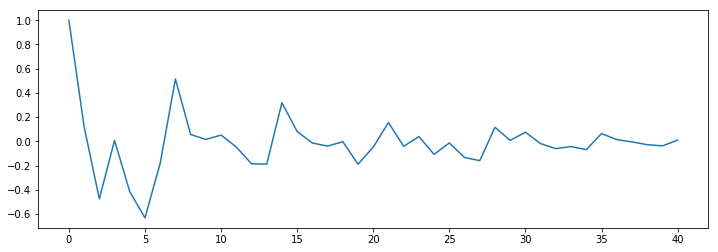

In [14]:
# pacf
# p:pertial 偏
# acf : 自己相関
train_pacf = sm.tsa.stattools.pacf(train_log_dif, nlags=40,
                                   method='ols')
#ols : 最小二乗法

fig = plt.figure(figsize=(12, 4))
plt.plot(train_pacf)
plt.show()

* lags: （偏）自己相関の次数

### 信頼区間付き

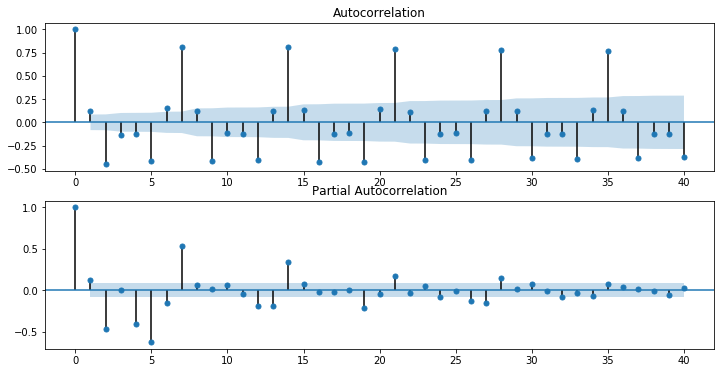

In [15]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211) # 2行1列の1つ目
fig = sm.graphics.tsa.plot_acf(train_log_dif, lags=40, ax=ax1) # 自己相関係数
ax2 = fig.add_subplot(212) # 2行1列の2つ目
fig = sm.graphics.tsa.plot_pacf(train_log_dif, lags=40, ax=ax2) # 偏自己相関係数

***
## ARモデル
* AR: AutoRegressive（自己回帰）

### ARモデルの生成と学習
* maxlag: ARモデルの次数
* ic: Information Criterion（情報量規準）＝採点方法を指定する  
aic: 赤池情報量規準という採点方法も用いる 
* trend: 定数を含めるかどうか  
c: 含める、nc: 含めない

In [16]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_log_dif, freq='D')
ar = ar.fit(maxlag=5, ic='aic', trend='nc')
ar.params # 各パラメータを確認

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


L1.user   -0.077471
L2.user   -0.629939
L3.user   -0.341253
L4.user   -0.303328
L5.user   -0.628494
dtype: float64

### ARモデルで予測

predict 予測

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


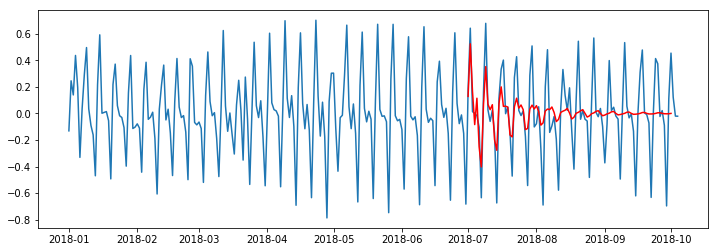

In [17]:
predict = ar.predict('2018-7', '2018-10')
plt.figure(figsize=(12, 4))
# test_log_dif 配列の index の year が 2017 より大きいデータをプロットしている
plt.plot(test_log_dif[test_log_dif.index.year > 2017])
plt.plot(predict, 'red')
plt.show()

この赤い図 予測線はうまく学習できていない
最初の方は、うまく予測でうきるが・・・

## MAモデル
* MA: Moving Average

### MAモデルの生成と学習
* order: ARMAモデルの次数
* mle: Maximum Likelihood Estimation（最尤法）

In [18]:
from statsmodels.tsa.arima_model import ARMA

ma = ARMA(train_log_dif, order=(0, 2), freq='D').fit(method='mle', trend='nc')
ma.params

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


ma.L1.user   -0.070853
ma.L2.user   -0.632742
dtype: float64

### MAモデルで予測

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


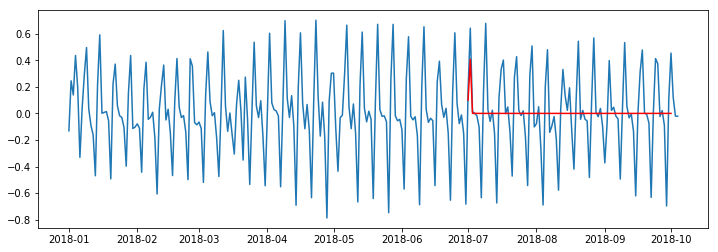

In [19]:
predict = ma.predict('2018-7', '2018-10')
plt.figure(figsize=(12, 4))
plt.plot(test_log_dif[test_log_dif.index.year > 2017])
plt.plot(predict, 'r')
plt.show()

## ARMAモデル
* ARMA: AutoRegressive Moving Average（自己回帰移動平均）
### AIC（赤池情報量規準）によるモデル選択

In [26]:
import warnings
warnings.filterwarnings('ignore')

# aic 規則に基づいて 最適なモデルを自動的に算出してくれうぇるコマンド
res = sm.tsa.arma_order_select_ic(train_log_dif, ic='aic', trend='nc',
                                 model_kw={'freq': 'D'})

In [23]:
res['aic']

,0,1,2
0,NaN,306.963188,144.770854
1,344.060729,275.682658,136.496439
2,208.482793,136.043473,118.467223
3,210.448968,136.432095,117.866579
4,110.832630,-6.427265,-272.980383


In [27]:
# aic もでるは 値が小さいほうが優秀なので、4,2 のモデルを採用する
res['aic_min_order']

(4, 2)

### ARMAモデル生成と学習

In [28]:
import warnings
warnings.filterwarnings('ignore')
arma = ARMA(train_log_dif, freq='D', order=(4, 2)).fit()
arma.params

const         0.007474
ar.L1.user    0.880229
ar.L2.user   -1.236143
ar.L3.user    0.497481
ar.L4.user   -0.692964
ma.L1.user   -1.237765
ma.L2.user    0.994461
dtype: float64

### ARMAモデルで予測
* plot_predict: 信頼区間付きで結果を描画

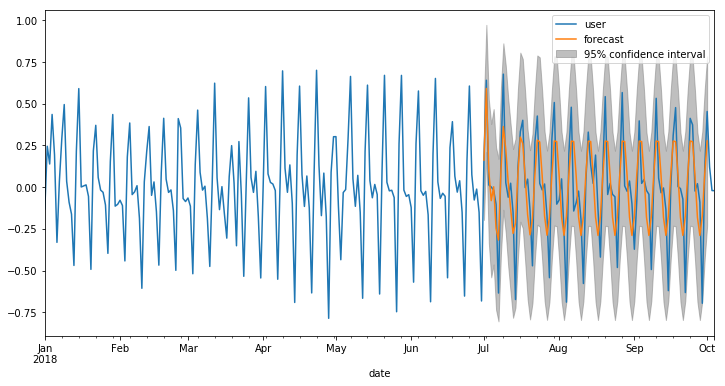

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
ax = test_log_dif.loc['2018':].plot(ax=ax)
# .plot_predict は 図の描画機能が
fig = arma.plot_predict('2018-7', '2018-10', ax=ax, plot_insample=False)
plt.show()


95% confidence intarval ：
95% の信頼性で予測できる 最大値

### 残差（ホワイトノイズ）$\varepsilon_t$の確認
* resid: RESIDual error（残差）
* 残差（ホワイトノイズ）は定常性を満たすので自己相関、偏自己相関からデータの性質を読み取ることができる

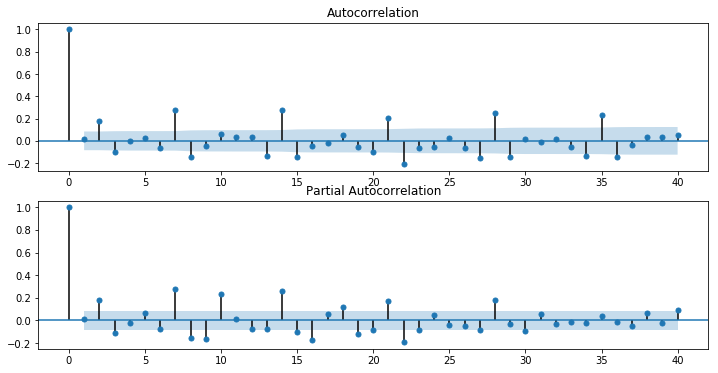

In [35]:
resid = arma.resid
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

## ARIMAモデル
* ARIMA: AutoRegressive Integrated Moving Average（自己回帰和分移動平均）
* 階差 $\Delta y_t:=y_t-y_{t-1}$ がARMA過程であると仮定->あとで足し合わせる

### ARIMAモデルの生成と学習
* order: ARIMAモデルの次数 $(p, d, q)$

In [36]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(train, freq='D', order=(2, 1, 2)).fit()
arima.params

const           5.937351
ar.L1.D.user    0.390327
ar.L2.D.user   -0.318734
ma.L1.D.user   -0.284353
ma.L2.D.user   -0.461588
dtype: float64

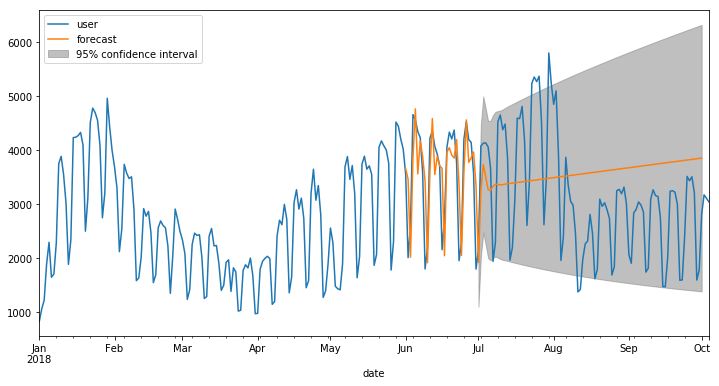

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax = test.loc['2018':].plot(ax=ax)
fig = arima.plot_predict('2018-6', '2018-10', ax=ax, plot_insample=False)
plt.show()

## SARIMAモデル
* SARIMA: Seasonal ARIMA（季節ARIMAモデル）

### SARIMAモデルの生成と学習
* seasonal_order: 季節パラメータの次数 $(sp, sd, sq, s)$  
$s$: 期間の長さ

下の 7 は 一週間を周期としてみた　という意図

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train, freq='D', order=(2, 1, 2), 
                 seasonal_order=(1, 1, 1, 7)).fit()
sarima.params

ar.L1          0.272519
ar.L2         -0.069295
ma.L1         -0.344622
ma.L2         -0.178694
ar.S.L7        0.113242
ma.S.L7       -0.782926
sigma2     60856.368313
dtype: float64

### 残差（ホワイトノイズ）$\varepsilon_t$の確認

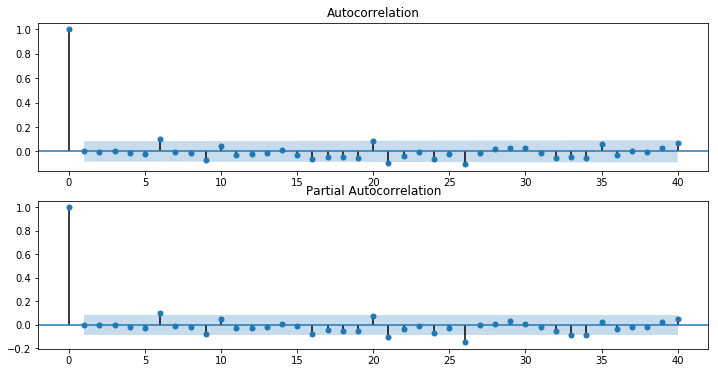

In [39]:
resid = sarima.resid
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

### SARIMAモデルで予測

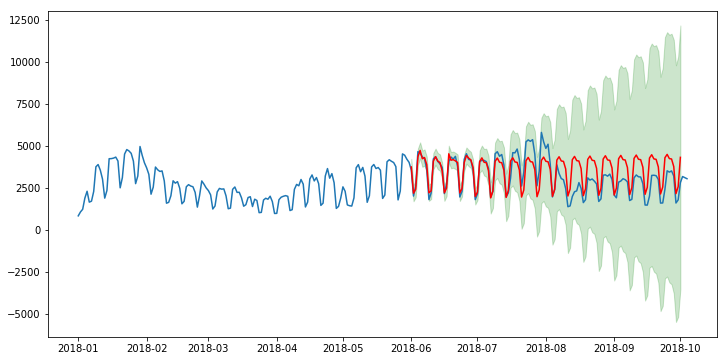

In [40]:
predict = sarima.predict('2018-6','2018-10')
predict_dy = sarima.get_prediction('2018-6','2018-10')
predict_dy_ci = predict_dy.conf_int(alpha=0.05)

plt.figure(figsize=(12,6))
plt.plot(test[test.index.year > 2017])
plt.plot(predict, 'r')
plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], 
                 predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.show()

***
## AICを用いたモデル選択
### 総当たり法でARIMAモデルの最適な次数を選択

In [ ]:
p_max, d_max, q_max = 2, 1, 2
pattern = p_max * (d_max + 1) * (q_max + 1)

result = pd.DataFrame(index=range(pattern), columns=['model', 'aic'])
num = 0
for p in range(1, p_max + 1):
    for d in range(d_max + 1):
        for q in range(q_max + 1):
            arima = ARIMA(
                train, order=(p, d, q), freq='D'
            ).fit(method='css', maxiter=300, dist=False)
            result.iloc[num]['model'] = 'order=({}, {}, {})'.format(p, d, q)
            result.iloc[num]['aic'] = arima.aic
            num += 1
            
result[result.aic == min(result.aic)]

,model,aic
11,"order=(2, 1, 2)",8112.79


In [30]:
p_max, q_max, d_max = 2, 2, 2
max_sp, max_sq, max_sd = 1, 1, 1

pattern = p_max * (q_max + 1) * (d_max + 1) \
            * (max_sp + 1) * (max_sq + 1) * (max_sd + 1)

result = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
num = 0
for p in range(1, p_max + 1):
    for d in range(d_max + 1):
        for q in range(q_max + 1):
            for sp in range(max_sp + 1):
                for sd in range(max_sd + 1):
                    for sq in range(max_sq + 1):
                        try:
                            sarima = SARIMAX(
                                train_log_dif, order=(p, d, q), 
                                seasonal_order=(sp, sd, sq, 7), 
                                enforce_stationarity = False, 
                                enforce_invertibility = False,
                                freq='D'
                            ).fit(method='bfgs', maxiter=300, disp=False)
                            result.iloc[num]['model'] = 'order=({},{},{}), season=({},{},{})'.format(p, d, q, sp, sd, sq)
                            result.iloc[num]['aic'] = sarima.aic
                            num += 1
                        except:
                            pass
                        
result[result.aic == min(result.aic)]

,model,aic


*** 
## 予測精度
### RMSE (scikit-learnを利用)

小さいほうがいい モデル

In [42]:
from sklearn.metrics import mean_squared_error

arima_predict = arima.predict('2018-6','2018-10')
print(arima_prediction.head())
print()
print(arima_predict.tail())
np.sqrt(mean_squared_error(arima_predict, test.loc['2018-06-01':'2018-10-01']))

2018-06-01    -360.739671
2018-06-02     -93.579186
2018-06-03       7.877618
2018-06-04    1240.211776
2018-06-05     106.380017
Freq: D, dtype: float64

2018-09-27    5.960244
2018-09-28    5.960244
2018-09-29    5.960244
2018-09-30    5.960244
2018-10-01    5.960244
Freq: D, dtype: float64


3386.1466142199884

In [43]:
sarima = SARIMAX(train, freq='D', order=(1, 0, 2), 
                 seasonal_order=(0, 1, 1, 7)).fit()
sarima_predict = sarima.predict('2018-6','2018-10')
print(sarima_predict.head())
print()
print(sarima_predict.tail())
np.sqrt(mean_squared_error(sarima_predict, test.loc['2018-06-01':'2018-10-01']))

2018-06-01    3670.354542
2018-06-02    2106.297831
2018-06-03    2355.325746
2018-06-04    4334.983447
2018-06-05    4663.614296
Freq: D, dtype: float64

2018-09-27    4013.537556
2018-09-28    3536.207281
2018-09-29    1860.002229
2018-09-30    2297.476747
2018-10-01    4087.084973
Freq: D, dtype: float64


777.4308837847467

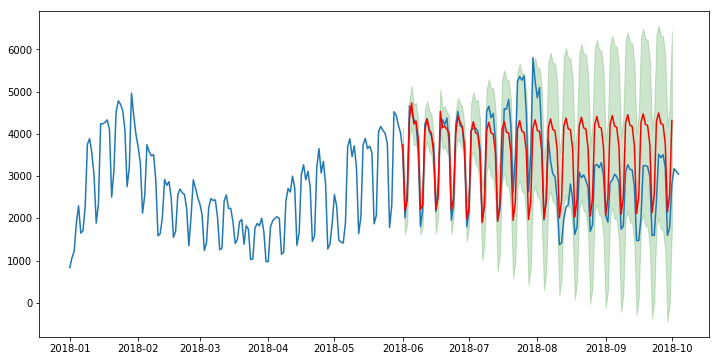

In [44]:
predict_dy = sarima.get_prediction('2018-6','2018-10')
predict_dy_ci = predict_dy.conf_int(alpha=0.05)

plt.figure(figsize=(12,6))
plt.plot(test[test.index.year > 2017])
plt.plot(predict, 'r')
plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], 
                 predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.show()